# 1. Assignment: CIFAR-10 Classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import datetime

%load_ext tensorboard

/Users/christinearnoldt/mambaforge/envs/iannwtf_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

## 1.1 Prepare the Dataset

First familiarise yourself with the dataset. It is included as a TensorFlow
Dataset but can also be obtained from other sources. Try to understand how it
works (information in the data, dataset size, image size, are there color chan-
nels, type the data is stored as, etc.). Understanding the data you are working
with and applying respective preprocessing steps is a major part of the process
for real life applications.
Now that you familiarised yourself with it, load the data and apply respective
preprocessing steps using a data pipeline (In case of problems refer to your old
homework tasks or the Courseware). 1 Visualize a sample of the dataset

### Familiarize with dataset and visualize samples

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/Users/christinearnoldt/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
     

2023-12-10 21:10:17.769212: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-10 21:10:17.769234: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 21:10:17.769240: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 21:10:17.769271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 21:10:17.769286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-10 21:10:17.856953: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected tr

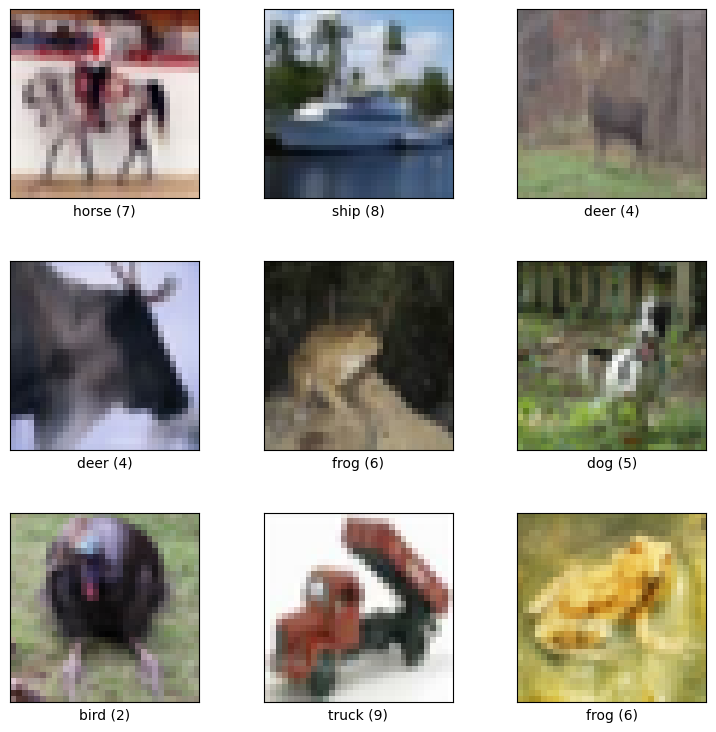

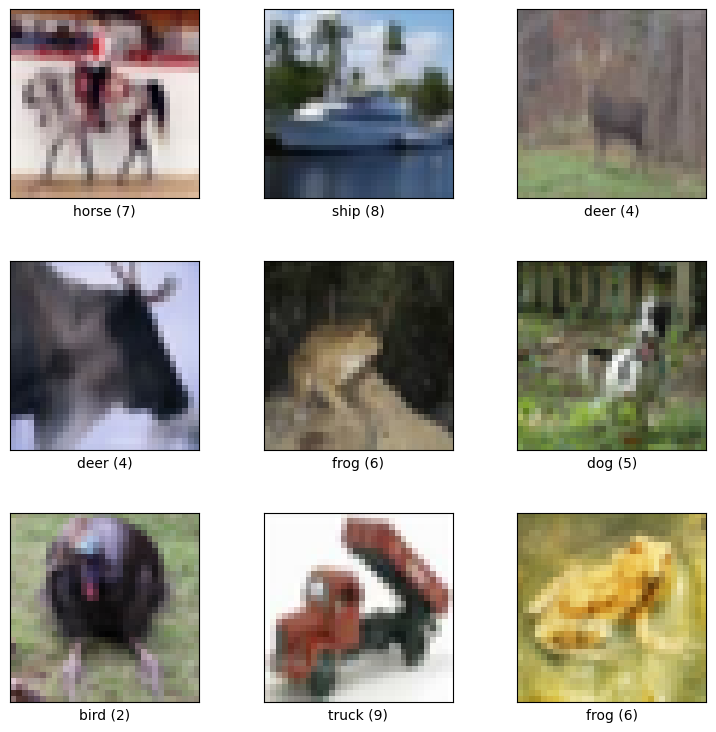

In [4]:
(train_data, test_data), ds_info = tfds.load(name='cifar10',
                                                split=['train','test'],
                                                as_supervised=True,
                                                with_info=True)
print(ds_info)
tfds.show_examples(train_data, ds_info)

### Prepare preprocessing

In [5]:
def preprocessing(img, label):
    # Convert image data type to float32
    img = tf.cast(img, tf.float32)
    # Normalize pixel values to the range [-1, 1]
    img = (img / 128) - 1
    # One-hot encode the label
    label = tf.one_hot(label, depth=10)
    return img, label

def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    # Load CIFAR-10 dataset with training and testing splits
    (train_data, test_data), ds_info = tfds.load(name='cifar10',
                                                split=['train', 'test'],
                                                as_supervised=True,
                                                with_info=True)
    # Apply preprocessing function to training and testing data
    train_data = train_data.map(lambda img, label: preprocessing(img, label))
    test_data = test_data.map(lambda img, label: preprocessing(img, label))
    # Shuffle, batch, and prefetch training data
    train_data = train_data.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(20)
    # Batch and prefetch testing data
    test_data = test_data.batch(batch_size).prefetch(20)
    return train_data, test_data, ds_info

In [6]:
train_data, test_data, ds_info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)

## 1.2 The CNN Model

Build a Convolutional Neural Network inspired by the information gained in
this weeks Courseware. You are going to need more than the dense-layers used
so far. Start with a basic structure and don’t necessarily think about optimizing
the architecture too much, as this will be part of the last step. 

In [7]:
class CNN_Model(tf.keras.Model):
    def __init__(self, size_of_blocks: [int], lr, opt):
        super(CNN_Model, self).__init__()
        
        # Initialize optimizer based on the specified option ('sgd' or 'adam')
        if opt == 'sgd':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        else:
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        # Define list of metrics for monitoring model performance
        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss"),
            tf.keras.metrics.CategoricalAccuracy(name="acc"),
        ]
        
        # Define categorical crossentropy loss function
        self.loss_f = tf.keras.losses.CategoricalCrossentropy()
        
        # Initialize a list to store convolutional layers
        self.model_layers = []
        
        # Create convolutional blocks with specified sizes
        for block in range(len(size_of_blocks)):
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2)))
        
        # Global average pooling layer
        self.global_pooling = tf.keras.layers.GlobalAveragePooling2D()
        
        # Output dense layer with softmax activation for classification
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
       
    @tf.function
    def call(self, x):
        # Forward pass through convolutional blocks
        for layer in self.model_layers:
            x = layer(x)
        # Global average pooling
        x = self.global_pooling(x)
        # Output layer for classification
        output = self.output_layer(x)
        return output
    
    # Function to reset metrics at the beginning of each epoch
    def reset_metrics(self):
        for metric in self.metrics_list:
            metric.reset_states()
    
    @tf.function
    def train_step(self, data):
        
        x, target = data
        # Forward pass and calculate loss
        with tf.GradientTape() as tape:
            pred = self(x)
            loss = self.loss_f(target, pred) + tf.reduce_sum(self.losses)
        # Calculate gradients and update model parameters
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars=zip(gradients, self.trainable_variables))
        
        # Update loss metric
        self.metrics[0].update_state(loss)
        
        # Update other metrics
        for metric in self.metrics[1:]:
            metric.update_state(target, pred)
        # Return metrics as a dictionary
        return {m.name: m.result() for m in self.metrics}
    
    @tf.function
    def test_step(self, data):
        # Unpack input data
        x, target = data
        # Forward pass and calculate loss
        pred = self(x)
        loss = self.loss_f(target, pred) + tf.reduce_sum(self.losses)
        
        # Update loss metric
        self.metrics[0].update_state(loss)
        
        # Update other metrics
        for metric in self.metrics[1:]:
            metric.update_state(target, pred)
        # Return metrics as a dictionary
        return {m.name: m.result() for m in self.metrics}


In [8]:
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

## 1.3 Training the network

Define a training loop function. Define your hyperparameters, think of an ap-
propriate loss function and optimizer and initialize everything. Store loss and
accuracy for training and test data. Training your network for a maximum of
15 epochs should be enough.

In [9]:
# Define where to save the log
config_name= "Run-1"
current_time_run1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time_run1}/train"
test_log_path = f"logs/{config_name}/{current_time_run1}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)

In [10]:
import tqdm

def training_loop(model, train, test, epochs, train_summary_writer, test_summary_writer):
    # Lists to store training and validation metrics across epochs
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    # Loop through epochs
    for epoch in range(epochs):
        
        # Training
        for data in tqdm.tqdm(train, position=0, leave=True, desc=f"Epoch {epoch}"):
            # Perform a training step using the model
            metrics = model.train_step(data)
            
            # Log training metrics to TensorBoard
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
        # Store training metrics for the epoch
        train_loss.append(metrics["loss"].numpy())
        train_acc.append(metrics["acc"].numpy())
        
        # Print and reset training metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        model.reset_metrics()

        # Testing
        for data in test:
            # Perform a testing step using the model
            metrics = model.test_step(data)

            # Log validation metrics to TensorBoard
            with test_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
        # Store validation metrics for the epoch
        val_loss.append(metrics["loss"].numpy())
        val_acc.append(metrics["acc"].numpy())
        
        # Print validation metrics
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # Reset validation metrics
        model.reset_metrics()
    
    # Return lists of training and validation metrics for analysis or plotting
    return train_loss, train_acc, val_loss, val_acc


In [11]:
train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)

Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]2023-12-10 21:10:19.475800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-10 21:10:19.569312: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
Epoch 0: 100%|██████████| 782/782 [00:17<00:00, 45.59it/s]


['loss: 1.8694512844085693', 'acc: 0.29548001289367676']
['val_loss: 1.651057481765747', 'val_acc: 0.38850000500679016']


Epoch 1: 100%|██████████| 782/782 [00:14<00:00, 52.61it/s]


['loss: 1.5667587518692017', 'acc: 0.41951999068260193']
['val_loss: 1.4743443727493286', 'val_acc: 0.45680001378059387']


Epoch 2: 100%|██████████| 782/782 [00:14<00:00, 54.83it/s]


['loss: 1.408554196357727', 'acc: 0.484279990196228']
['val_loss: 1.3759957551956177', 'val_acc: 0.49900001287460327']


Epoch 3: 100%|██████████| 782/782 [00:14<00:00, 55.65it/s]


['loss: 1.302268147468567', 'acc: 0.528980016708374']
['val_loss: 1.3133805990219116', 'val_acc: 0.5199999809265137']


Epoch 4: 100%|██████████| 782/782 [00:14<00:00, 55.57it/s]


['loss: 1.2109174728393555', 'acc: 0.5618000030517578']
['val_loss: 1.1647748947143555', 'val_acc: 0.5820000171661377']


Epoch 5: 100%|██████████| 782/782 [00:13<00:00, 55.88it/s]


['loss: 1.1397831439971924', 'acc: 0.5889000296592712']
['val_loss: 1.1273434162139893', 'val_acc: 0.5935999751091003']


Epoch 6: 100%|██████████| 782/782 [00:14<00:00, 55.09it/s]


['loss: 1.067620038986206', 'acc: 0.6169599890708923']
['val_loss: 1.081231951713562', 'val_acc: 0.6122999787330627']


Epoch 7: 100%|██████████| 782/782 [00:13<00:00, 56.90it/s]


['loss: 1.0152748823165894', 'acc: 0.6354600191116333']
['val_loss: 1.0558191537857056', 'val_acc: 0.6241999864578247']


Epoch 8: 100%|██████████| 782/782 [00:13<00:00, 58.97it/s]


['loss: 0.9672721028327942', 'acc: 0.654259979724884']
['val_loss: 1.0528852939605713', 'val_acc: 0.6291000247001648']


Epoch 9: 100%|██████████| 782/782 [00:13<00:00, 59.45it/s]


['loss: 0.9236972332000732', 'acc: 0.6708800196647644']
['val_loss: 1.0299406051635742', 'val_acc: 0.6412000060081482']


Epoch 10: 100%|██████████| 782/782 [00:13<00:00, 57.24it/s]


['loss: 0.8744940161705017', 'acc: 0.6858199834823608']
['val_loss: 0.9923276305198669', 'val_acc: 0.6513000130653381']


Epoch 11: 100%|██████████| 782/782 [00:13<00:00, 58.02it/s]


['loss: 0.8401748538017273', 'acc: 0.6975799798965454']
['val_loss: 0.9872919321060181', 'val_acc: 0.6581000089645386']


Epoch 12: 100%|██████████| 782/782 [00:13<00:00, 57.04it/s]


['loss: 0.7991263270378113', 'acc: 0.7131400108337402']
['val_loss: 0.9890964031219482', 'val_acc: 0.6592000126838684']


Epoch 13: 100%|██████████| 782/782 [00:13<00:00, 58.73it/s]


['loss: 0.757495641708374', 'acc: 0.7287999987602234']
['val_loss: 0.9849504828453064', 'val_acc: 0.6608999967575073']


Epoch 14: 100%|██████████| 782/782 [00:13<00:00, 59.68it/s]


['loss: 0.7203512787818909', 'acc: 0.7434999942779541']
['val_loss: 1.0435607433319092', 'val_acc: 0.6499999761581421']


## 1.4 Visualization

After training visualize the performance of your model and the values that you
collected during training and testing.

In [12]:
%tensorboard --logdir logs

In [13]:
import matplotlib.pyplot as plt
def visualization (train_losses, train_accuracies, val_losses, val_accuracies):
    """ Visualizes accuracy and loss for training and test data using
        the mean of each epoch.
        
        Loss is displayed in a regular line, accuracy in a dotted line.
        Training data is displayed in blue, test data in red.
    
    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    val_losses : numpy . ndarray
    val losses
    val_accuracies : numpy . ndarray
    val accuracies
    """
    #plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(val_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(val_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "validation loss", "train accuracy", "validation accuracy"))
    plt.show()

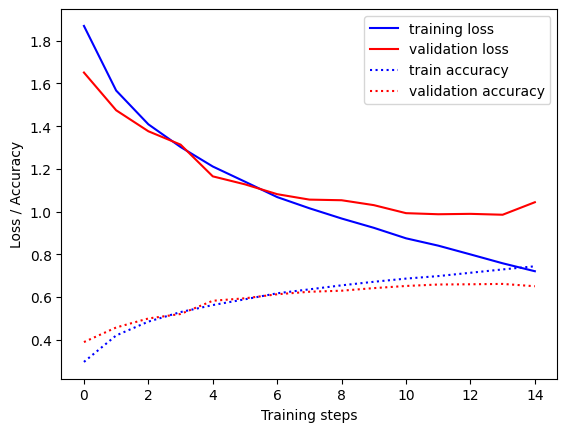

In [14]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

# 2 Adjust hyperparameters and architecture

Now it is time to learn about the influence hyperparameter and training choices
can make. Try out:
- Two different Learning Rates
- Two different Architectures (e.g. number and size of layers)
- Two different optimizers (Including Adam and one other)

In total this should create 8 respective settings, for each of which we ask you to plot:
- Training Accuracy
- Training Loss
- Test Accuracy
- Test Loss

To be explicit: This should result in a total of 8 times four plots!

## 2.1 Learning Rate Experiments

Epoch 0: 100%|██████████| 782/782 [00:15<00:00, 49.14it/s]


['loss: 2.0073859691619873', 'acc: 0.24018000066280365']
['val_loss: 1.8679399490356445', 'val_acc: 0.30090001225471497']


Epoch 1: 100%|██████████| 782/782 [00:13<00:00, 57.56it/s]


['loss: 1.793533205986023', 'acc: 0.31762000918388367']
['val_loss: 1.7518763542175293', 'val_acc: 0.3345000147819519']


Epoch 2: 100%|██████████| 782/782 [00:13<00:00, 58.87it/s]


['loss: 1.7366917133331299', 'acc: 0.34602001309394836']
['val_loss: 1.703210473060608', 'val_acc: 0.35429999232292175']


Epoch 3: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


['loss: 1.697075366973877', 'acc: 0.3609600067138672']
['val_loss: 1.672699213027954', 'val_acc: 0.366100013256073']


Epoch 4: 100%|██████████| 782/782 [00:14<00:00, 53.30it/s]


['loss: 1.6682019233703613', 'acc: 0.37314000725746155']
['val_loss: 1.6585924625396729', 'val_acc: 0.3702000081539154']


Epoch 5: 100%|██████████| 782/782 [00:14<00:00, 53.82it/s]


['loss: 1.6411254405975342', 'acc: 0.38148000836372375']
['val_loss: 1.628680944442749', 'val_acc: 0.3846000134944916']


Epoch 6: 100%|██████████| 782/782 [00:13<00:00, 55.97it/s]


['loss: 1.6148383617401123', 'acc: 0.39259999990463257']
['val_loss: 1.6100244522094727', 'val_acc: 0.391400009393692']


Epoch 7: 100%|██████████| 782/782 [00:13<00:00, 56.14it/s]


['loss: 1.5920383930206299', 'acc: 0.4023999869823456']
['val_loss: 1.574031114578247', 'val_acc: 0.40310001373291016']


Epoch 8: 100%|██████████| 782/782 [00:13<00:00, 56.58it/s]


['loss: 1.5700833797454834', 'acc: 0.41110000014305115']
['val_loss: 1.5874272584915161', 'val_acc: 0.4034000039100647']


Epoch 9: 100%|██████████| 782/782 [00:13<00:00, 56.79it/s]


['loss: 1.5513598918914795', 'acc: 0.4181399941444397']
['val_loss: 1.5513269901275635', 'val_acc: 0.41600000858306885']


Epoch 10: 100%|██████████| 782/782 [00:13<00:00, 56.74it/s]


['loss: 1.5298080444335938', 'acc: 0.4266200065612793']
['val_loss: 1.5064834356307983', 'val_acc: 0.43389999866485596']


Epoch 11: 100%|██████████| 782/782 [00:14<00:00, 53.79it/s]


['loss: 1.505109190940857', 'acc: 0.4359799921512604']
['val_loss: 1.4937989711761475', 'val_acc: 0.4399000108242035']


Epoch 12: 100%|██████████| 782/782 [00:13<00:00, 58.08it/s]


['loss: 1.4843450784683228', 'acc: 0.4458000063896179']
['val_loss: 1.478555679321289', 'val_acc: 0.453900009393692']


Epoch 13: 100%|██████████| 782/782 [00:13<00:00, 56.60it/s]


['loss: 1.4639939069747925', 'acc: 0.4548400044441223']
['val_loss: 1.4464701414108276', 'val_acc: 0.4587000012397766']


Epoch 14: 100%|██████████| 782/782 [00:13<00:00, 56.30it/s]


['loss: 1.4399833679199219', 'acc: 0.4644399881362915']
['val_loss: 1.44911789894104', 'val_acc: 0.4603999853134155']


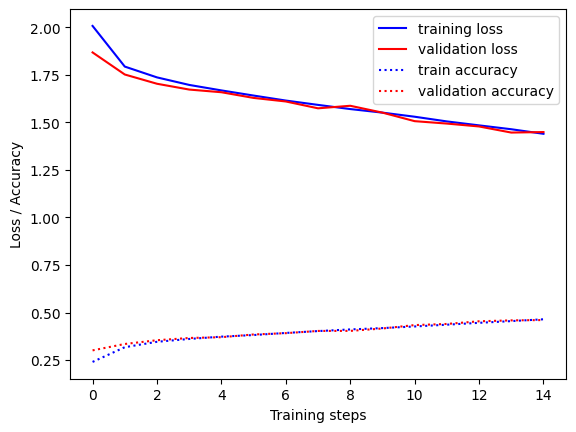

In [15]:
'''
1. Experiment

Learning rate: 0.0001
Architecture: [5,10,32,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.0001

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:16<00:00, 46.34it/s]


['loss: 1.8423975706100464', 'acc: 0.28025999665260315']
['val_loss: 1.6390019655227661', 'val_acc: 0.37599998712539673']


Epoch 1: 100%|██████████| 782/782 [00:13<00:00, 56.79it/s]


['loss: 1.5583817958831787', 'acc: 0.41019999980926514']
['val_loss: 1.472973108291626', 'val_acc: 0.45350000262260437']


Epoch 2: 100%|██████████| 782/782 [00:14<00:00, 55.71it/s]


['loss: 1.3892595767974854', 'acc: 0.4875200092792511']
['val_loss: 1.3792109489440918', 'val_acc: 0.5016000270843506']


Epoch 3: 100%|██████████| 782/782 [00:13<00:00, 55.90it/s]


['loss: 1.2597534656524658', 'acc: 0.5423399806022644']
['val_loss: 1.2912490367889404', 'val_acc: 0.5327000021934509']


Epoch 4: 100%|██████████| 782/782 [00:13<00:00, 56.74it/s]


['loss: 1.1626033782958984', 'acc: 0.5821599960327148']
['val_loss: 1.207092046737671', 'val_acc: 0.5769000053405762']


Epoch 5: 100%|██████████| 782/782 [00:14<00:00, 54.56it/s]


['loss: 1.0761866569519043', 'acc: 0.6134999990463257']
['val_loss: 1.1414763927459717', 'val_acc: 0.5983999967575073']


Epoch 6: 100%|██████████| 782/782 [00:13<00:00, 56.72it/s]


['loss: 1.009850263595581', 'acc: 0.6412000060081482']
['val_loss: 1.0767024755477905', 'val_acc: 0.6137999892234802']


Epoch 7: 100%|██████████| 782/782 [00:14<00:00, 52.72it/s]


['loss: 0.9505414366722107', 'acc: 0.6629199981689453']
['val_loss: 1.0176846981048584', 'val_acc: 0.6464999914169312']


Epoch 8: 100%|██████████| 782/782 [00:15<00:00, 51.73it/s]


['loss: 0.9076933264732361', 'acc: 0.6789199709892273']
['val_loss: 1.0394902229309082', 'val_acc: 0.6389999985694885']


Epoch 9: 100%|██████████| 782/782 [00:14<00:00, 52.54it/s]


['loss: 0.8605641722679138', 'acc: 0.6947600245475769']
['val_loss: 1.0174826383590698', 'val_acc: 0.6516000032424927']


Epoch 10: 100%|██████████| 782/782 [00:13<00:00, 57.04it/s]


['loss: 0.8265385627746582', 'acc: 0.7061399817466736']
['val_loss: 1.0058165788650513', 'val_acc: 0.6503999829292297']


Epoch 11: 100%|██████████| 782/782 [00:13<00:00, 57.52it/s]


['loss: 0.7926324605941772', 'acc: 0.7182199954986572']
['val_loss: 1.0105074644088745', 'val_acc: 0.6607999801635742']


Epoch 12: 100%|██████████| 782/782 [00:13<00:00, 57.58it/s]


['loss: 0.7601787447929382', 'acc: 0.7290199995040894']
['val_loss: 1.0229263305664062', 'val_acc: 0.6553999781608582']


Epoch 13: 100%|██████████| 782/782 [00:13<00:00, 57.82it/s]


['loss: 0.729252278804779', 'acc: 0.7414000034332275']
['val_loss: 1.039568543434143', 'val_acc: 0.65829998254776']


Epoch 14: 100%|██████████| 782/782 [00:13<00:00, 58.24it/s]


['loss: 0.7047469019889832', 'acc: 0.7490599751472473']
['val_loss: 1.087161898612976', 'val_acc: 0.657800018787384']


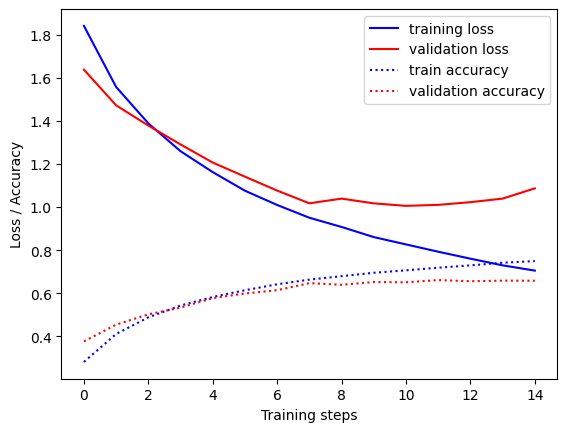

In [16]:
'''
2. Experiment

Learning rate: 0.002
Architecture: [5,10,32,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.002

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

## 2.2 Architecture Experiments

Epoch 0: 100%|██████████| 782/782 [00:42<00:00, 18.58it/s]


['loss: 1.8327561616897583', 'acc: 0.3027400076389313']
['val_loss: 1.5699436664581299', 'val_acc: 0.40720000863075256']


Epoch 1: 100%|██████████| 782/782 [00:39<00:00, 19.65it/s]


['loss: 1.501085877418518', 'acc: 0.43860000371932983']
['val_loss: 1.383257508277893', 'val_acc: 0.48579999804496765']


Epoch 2: 100%|██████████| 782/782 [00:39<00:00, 19.58it/s]


['loss: 1.3290842771530151', 'acc: 0.5092200040817261']
['val_loss: 1.2619054317474365', 'val_acc: 0.5462999939918518']


Epoch 3: 100%|██████████| 782/782 [00:39<00:00, 19.60it/s]


['loss: 1.2140095233917236', 'acc: 0.5570600032806396']
['val_loss: 1.2001755237579346', 'val_acc: 0.5724999904632568']


Epoch 4: 100%|██████████| 782/782 [00:39<00:00, 19.58it/s]


['loss: 1.1198906898498535', 'acc: 0.5944799780845642']
['val_loss: 1.1152609586715698', 'val_acc: 0.6008999943733215']


Epoch 5: 100%|██████████| 782/782 [00:39<00:00, 19.58it/s]


['loss: 1.0495988130569458', 'acc: 0.6200799942016602']
['val_loss: 1.0823324918746948', 'val_acc: 0.6229000091552734']


Epoch 6: 100%|██████████| 782/782 [00:39<00:00, 19.61it/s]


['loss: 0.9897862672805786', 'acc: 0.6456000208854675']
['val_loss: 1.0135784149169922', 'val_acc: 0.6416000127792358']


Epoch 7: 100%|██████████| 782/782 [00:39<00:00, 19.61it/s]


['loss: 0.9364275932312012', 'acc: 0.6644999980926514']
['val_loss: 1.004993200302124', 'val_acc: 0.6473000049591064']


Epoch 8: 100%|██████████| 782/782 [00:39<00:00, 19.63it/s]


['loss: 0.8837923407554626', 'acc: 0.6857200264930725']
['val_loss: 0.8864832520484924', 'val_acc: 0.6886000037193298']


Epoch 9: 100%|██████████| 782/782 [00:39<00:00, 19.61it/s]


['loss: 0.8357298970222473', 'acc: 0.7008000016212463']
['val_loss: 0.877713143825531', 'val_acc: 0.6929000020027161']


Epoch 10: 100%|██████████| 782/782 [00:40<00:00, 19.53it/s]


['loss: 0.7943170666694641', 'acc: 0.7178400158882141']
['val_loss: 0.8802902102470398', 'val_acc: 0.6916000247001648']


Epoch 11: 100%|██████████| 782/782 [00:39<00:00, 19.60it/s]


['loss: 0.7578879594802856', 'acc: 0.7299399971961975']
['val_loss: 0.8242754340171814', 'val_acc: 0.7142999768257141']


Epoch 12: 100%|██████████| 782/782 [00:39<00:00, 19.64it/s]


['loss: 0.7189892530441284', 'acc: 0.7442799806594849']
['val_loss: 0.8137297034263611', 'val_acc: 0.7168999910354614']


Epoch 13: 100%|██████████| 782/782 [00:39<00:00, 19.63it/s]


['loss: 0.6868235468864441', 'acc: 0.7562800049781799']
['val_loss: 0.8014774918556213', 'val_acc: 0.722000002861023']


Epoch 14: 100%|██████████| 782/782 [00:39<00:00, 19.62it/s]


['loss: 0.65593421459198', 'acc: 0.7667800188064575']
['val_loss: 0.7746806740760803', 'val_acc: 0.7330999970436096']


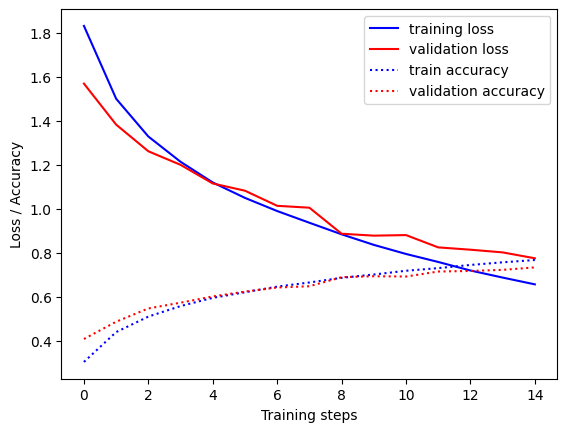

In [17]:
'''
3. Experiment

Learning rate: 0.0001
Architecture: [64,164,164,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.0001

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:21<00:00, 36.21it/s]


['loss: 1.7973556518554688', 'acc: 0.3166399896144867']
['val_loss: 1.6178474426269531', 'val_acc: 0.4058000147342682']


Epoch 1: 100%|██████████| 782/782 [00:18<00:00, 41.54it/s]


['loss: 1.4396411180496216', 'acc: 0.46818000078201294']
['val_loss: 1.340394377708435', 'val_acc: 0.510699987411499']


Epoch 2: 100%|██████████| 782/782 [00:18<00:00, 42.33it/s]


['loss: 1.2290544509887695', 'acc: 0.5538399815559387']
['val_loss: 1.1671401262283325', 'val_acc: 0.5827000141143799']


Epoch 3: 100%|██████████| 782/782 [00:18<00:00, 42.60it/s]


['loss: 1.0785009860992432', 'acc: 0.6122000217437744']
['val_loss: 1.0555123090744019', 'val_acc: 0.6230999827384949']


Epoch 4: 100%|██████████| 782/782 [00:18<00:00, 42.46it/s]


['loss: 0.9616295099258423', 'acc: 0.6578599810600281']
['val_loss: 1.0036767721176147', 'val_acc: 0.6463000178337097']


Epoch 5: 100%|██████████| 782/782 [00:18<00:00, 42.62it/s]


['loss: 0.8768928050994873', 'acc: 0.686680018901825']
['val_loss: 1.0363165140151978', 'val_acc: 0.6395000219345093']


Epoch 6: 100%|██████████| 782/782 [00:18<00:00, 42.33it/s]


['loss: 0.8051757216453552', 'acc: 0.7146999835968018']
['val_loss: 0.8773184418678284', 'val_acc: 0.7032999992370605']


Epoch 7: 100%|██████████| 782/782 [00:18<00:00, 42.60it/s]


['loss: 0.7496317028999329', 'acc: 0.733299970626831']
['val_loss: 0.881926417350769', 'val_acc: 0.6984000205993652']


Epoch 8: 100%|██████████| 782/782 [00:18<00:00, 43.12it/s]


['loss: 0.7050914764404297', 'acc: 0.7498999834060669']
['val_loss: 0.8395053148269653', 'val_acc: 0.7189000248908997']


Epoch 9: 100%|██████████| 782/782 [00:18<00:00, 42.98it/s]


['loss: 0.6703301668167114', 'acc: 0.7620800137519836']
['val_loss: 0.8313533663749695', 'val_acc: 0.7184000015258789']


Epoch 10: 100%|██████████| 782/782 [00:18<00:00, 42.90it/s]


['loss: 0.6367760896682739', 'acc: 0.7751200199127197']
['val_loss: 0.8849844932556152', 'val_acc: 0.7124000191688538']


Epoch 11: 100%|██████████| 782/782 [00:18<00:00, 42.79it/s]


['loss: 0.61288982629776', 'acc: 0.7823799848556519']
['val_loss: 0.893357515335083', 'val_acc: 0.707099974155426']


Epoch 12: 100%|██████████| 782/782 [00:18<00:00, 42.82it/s]


['loss: 0.5898647308349609', 'acc: 0.7935600280761719']
['val_loss: 0.8520214557647705', 'val_acc: 0.7217000126838684']


Epoch 13: 100%|██████████| 782/782 [00:18<00:00, 42.60it/s]


['loss: 0.5645415782928467', 'acc: 0.799839973449707']
['val_loss: 0.8590713739395142', 'val_acc: 0.7271000146865845']


Epoch 14: 100%|██████████| 782/782 [00:18<00:00, 42.80it/s]


['loss: 0.5351577997207642', 'acc: 0.8111400008201599']
['val_loss: 0.876603901386261', 'val_acc: 0.7278000116348267']


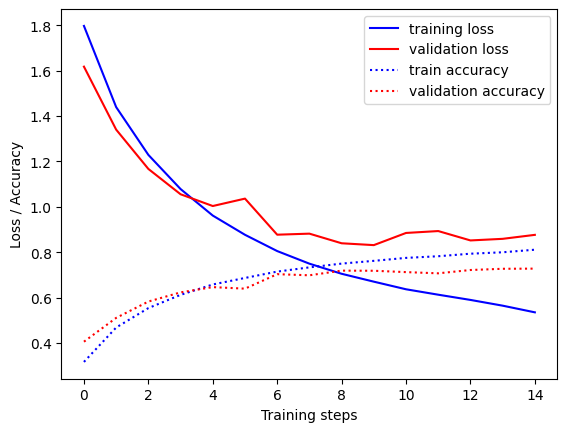

In [18]:
'''
4. Experiment

Learning rate: 0.002
Architecture: [64,164,164,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.002

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,32,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

## 2.3 Optimizer Experiments

Epoch 0: 100%|██████████| 782/782 [00:14<00:00, 52.58it/s]


['loss: 2.302579164505005', 'acc: 0.10502000153064728']
['val_loss: 2.3025763034820557', 'val_acc: 0.10350000113248825']


Epoch 1: 100%|██████████| 782/782 [00:12<00:00, 63.02it/s]


['loss: 2.3025763034820557', 'acc: 0.1057400032877922']
['val_loss: 2.3025739192962646', 'val_acc: 0.1054999977350235']


Epoch 2: 100%|██████████| 782/782 [00:12<00:00, 62.99it/s]


['loss: 2.30257248878479', 'acc: 0.10676000267267227']
['val_loss: 2.3025708198547363', 'val_acc: 0.10750000178813934']


Epoch 3: 100%|██████████| 782/782 [00:12<00:00, 63.74it/s]


['loss: 2.302570343017578', 'acc: 0.10809999704360962']
['val_loss: 2.302565574645996', 'val_acc: 0.10689999908208847']


Epoch 4: 100%|██████████| 782/782 [00:12<00:00, 63.63it/s]


['loss: 2.302565813064575', 'acc: 0.10794000327587128']
['val_loss: 2.3025622367858887', 'val_acc: 0.11020000278949738']


Epoch 5: 100%|██████████| 782/782 [00:12<00:00, 62.06it/s]


['loss: 2.3025619983673096', 'acc: 0.10982000082731247']
['val_loss: 2.302558183670044', 'val_acc: 0.11349999904632568']


Epoch 6: 100%|██████████| 782/782 [00:13<00:00, 59.50it/s]


['loss: 2.3025596141815186', 'acc: 0.11168000102043152']
['val_loss: 2.3025546073913574', 'val_acc: 0.11559999734163284']


Epoch 7: 100%|██████████| 782/782 [00:12<00:00, 62.03it/s]


['loss: 2.3025574684143066', 'acc: 0.11410000175237656']
['val_loss: 2.302551746368408', 'val_acc: 0.11640000343322754']


Epoch 8: 100%|██████████| 782/782 [00:12<00:00, 62.63it/s]


['loss: 2.3025543689727783', 'acc: 0.11683999747037888']
['val_loss: 2.3025481700897217', 'val_acc: 0.12250000238418579']


Epoch 9: 100%|██████████| 782/782 [00:12<00:00, 62.07it/s]


['loss: 2.3025522232055664', 'acc: 0.12031999975442886']
['val_loss: 2.302544355392456', 'val_acc: 0.125']


Epoch 10: 100%|██████████| 782/782 [00:12<00:00, 62.14it/s]


['loss: 2.3025472164154053', 'acc: 0.12225999683141708']
['val_loss: 2.3025429248809814', 'val_acc: 0.12849999964237213']


Epoch 11: 100%|██████████| 782/782 [00:12<00:00, 62.09it/s]


['loss: 2.3025455474853516', 'acc: 0.12530000507831573']
['val_loss: 2.3025405406951904', 'val_acc: 0.12860000133514404']


Epoch 12: 100%|██████████| 782/782 [00:12<00:00, 62.43it/s]


['loss: 2.3025434017181396', 'acc: 0.12615999579429626']
['val_loss: 2.3025381565093994', 'val_acc: 0.12939999997615814']


Epoch 13: 100%|██████████| 782/782 [00:12<00:00, 62.41it/s]


['loss: 2.3025405406951904', 'acc: 0.12601999938488007']
['val_loss: 2.302536725997925', 'val_acc: 0.13009999692440033']


Epoch 14: 100%|██████████| 782/782 [00:12<00:00, 63.66it/s]


['loss: 2.3025405406951904', 'acc: 0.12678000330924988']
['val_loss: 2.3025360107421875', 'val_acc: 0.13040000200271606']


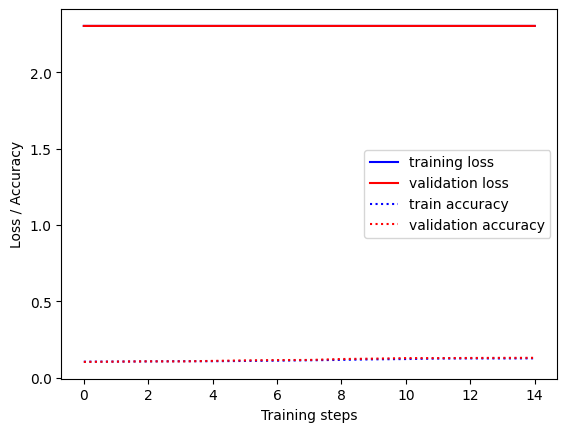

In [19]:
'''
5. Experiment

Learning rate: 0.0001
Architecture: [5,10,32,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.0001
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:15<00:00, 51.41it/s]


['loss: 2.302920341491699', 'acc: 0.10013999789953232']
['val_loss: 2.302615165710449', 'val_acc: 0.0949999988079071']


Epoch 1: 100%|██████████| 782/782 [00:12<00:00, 61.98it/s]


['loss: 2.302450180053711', 'acc: 0.10183999687433243']
['val_loss: 2.302295207977295', 'val_acc: 0.10849999636411667']


Epoch 2: 100%|██████████| 782/782 [00:12<00:00, 63.96it/s]


['loss: 2.302194356918335', 'acc: 0.11264000087976456']
['val_loss: 2.302044630050659', 'val_acc: 0.10970000177621841']


Epoch 3: 100%|██████████| 782/782 [00:12<00:00, 63.93it/s]


['loss: 2.301945209503174', 'acc: 0.12530000507831573']
['val_loss: 2.301776885986328', 'val_acc: 0.11389999836683273']


Epoch 4: 100%|██████████| 782/782 [00:12<00:00, 64.22it/s]


['loss: 2.3016891479492188', 'acc: 0.12941999733448029']
['val_loss: 2.301504135131836', 'val_acc: 0.1242000013589859']


Epoch 5: 100%|██████████| 782/782 [00:12<00:00, 62.90it/s]


['loss: 2.3013978004455566', 'acc: 0.1363999992609024']
['val_loss: 2.3011634349823', 'val_acc: 0.1370999962091446']


Epoch 6: 100%|██████████| 782/782 [00:12<00:00, 63.28it/s]


['loss: 2.301025629043579', 'acc: 0.14205999672412872']
['val_loss: 2.3007140159606934', 'val_acc: 0.13950000703334808']


Epoch 7: 100%|██████████| 782/782 [00:12<00:00, 63.75it/s]


['loss: 2.300513505935669', 'acc: 0.14448000490665436']
['val_loss: 2.300086736679077', 'val_acc: 0.14419999718666077']


Epoch 8: 100%|██████████| 782/782 [00:12<00:00, 63.91it/s]


['loss: 2.2997734546661377', 'acc: 0.1467600017786026']
['val_loss: 2.299149990081787', 'val_acc: 0.1454000025987625']


Epoch 9: 100%|██████████| 782/782 [00:12<00:00, 63.83it/s]


['loss: 2.2985999584198', 'acc: 0.14815999567508698']
['val_loss: 2.2976043224334717', 'val_acc: 0.1485999971628189']


Epoch 10: 100%|██████████| 782/782 [00:12<00:00, 62.64it/s]


['loss: 2.2966790199279785', 'acc: 0.14990000426769257']
['val_loss: 2.2951056957244873', 'val_acc: 0.15230000019073486']


Epoch 11: 100%|██████████| 782/782 [00:12<00:00, 62.62it/s]


['loss: 2.293470859527588', 'acc: 0.1521800011396408']
['val_loss: 2.290714740753174', 'val_acc: 0.15539999306201935']


Epoch 12: 100%|██████████| 782/782 [00:12<00:00, 63.42it/s]


['loss: 2.2873682975769043', 'acc: 0.1551000028848648']
['val_loss: 2.2816977500915527', 'val_acc: 0.1597999930381775']


Epoch 13: 100%|██████████| 782/782 [00:12<00:00, 63.40it/s]


['loss: 2.272488832473755', 'acc: 0.1595200002193451']
['val_loss: 2.256058931350708', 'val_acc: 0.16269999742507935']


Epoch 14: 100%|██████████| 782/782 [00:12<00:00, 62.93it/s]


['loss: 2.2242612838745117', 'acc: 0.164560005068779']
['val_loss: 2.186967372894287', 'val_acc: 0.17149999737739563']


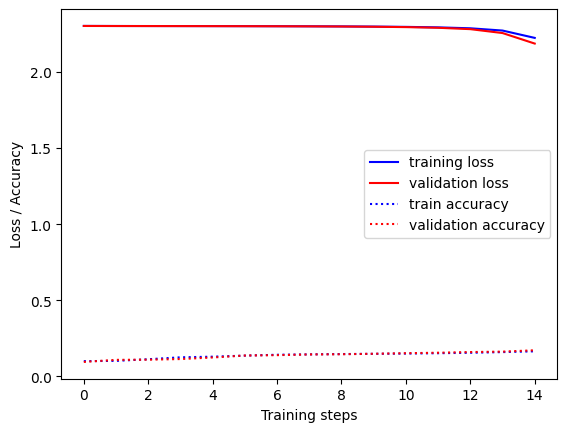

In [20]:
'''
6. Experiment

Learning rate: 0.002
Architecture: [5,10,32,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.002
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:41<00:00, 19.05it/s]


['loss: 2.302619218826294', 'acc: 0.10000000149011612']
['val_loss: 2.302617073059082', 'val_acc: 0.10000000149011612']


Epoch 1: 100%|██████████| 782/782 [00:38<00:00, 20.17it/s]


['loss: 2.302612543106079', 'acc: 0.09988000243902206']
['val_loss: 2.302611827850342', 'val_acc: 0.09939999878406525']


Epoch 2: 100%|██████████| 782/782 [00:38<00:00, 20.21it/s]


['loss: 2.302608013153076', 'acc: 0.097680002450943']
['val_loss: 2.3026063442230225', 'val_acc: 0.093299999833107']


Epoch 3: 100%|██████████| 782/782 [00:38<00:00, 20.20it/s]


['loss: 2.3025999069213867', 'acc: 0.09055999666452408']
['val_loss: 2.3025996685028076', 'val_acc: 0.09120000153779984']


Epoch 4: 100%|██████████| 782/782 [00:38<00:00, 20.20it/s]


['loss: 2.3025968074798584', 'acc: 0.08934000134468079']
['val_loss: 2.30259370803833', 'val_acc: 0.09380000084638596']


Epoch 5: 100%|██████████| 782/782 [00:38<00:00, 20.24it/s]


['loss: 2.3025901317596436', 'acc: 0.0946199968457222']
['val_loss: 2.3025872707366943', 'val_acc: 0.09719999879598618']


Epoch 6: 100%|██████████| 782/782 [00:39<00:00, 19.95it/s]


['loss: 2.302584409713745', 'acc: 0.09905999898910522']
['val_loss: 2.3025808334350586', 'val_acc: 0.10119999945163727']


Epoch 7: 100%|██████████| 782/782 [00:38<00:00, 20.07it/s]


['loss: 2.3025777339935303', 'acc: 0.1019200012087822']
['val_loss: 2.302574396133423', 'val_acc: 0.10300000011920929']


Epoch 8: 100%|██████████| 782/782 [00:38<00:00, 20.10it/s]


['loss: 2.3025708198547363', 'acc: 0.10286000370979309']
['val_loss: 2.3025691509246826', 'val_acc: 0.10369999706745148']


Epoch 9: 100%|██████████| 782/782 [00:38<00:00, 20.08it/s]


['loss: 2.3025660514831543', 'acc: 0.10313999652862549']
['val_loss: 2.3025643825531006', 'val_acc: 0.10339999943971634']


Epoch 10: 100%|██████████| 782/782 [00:38<00:00, 20.10it/s]


['loss: 2.3025593757629395', 'acc: 0.10329999774694443']
['val_loss: 2.3025598526000977', 'val_acc: 0.10329999774694443']


Epoch 11: 100%|██████████| 782/782 [00:38<00:00, 20.10it/s]


['loss: 2.3025577068328857', 'acc: 0.1035199984908104']
['val_loss: 2.3025548458099365', 'val_acc: 0.10329999774694443']


Epoch 12: 100%|██████████| 782/782 [00:38<00:00, 20.09it/s]


['loss: 2.3025546073913574', 'acc: 0.10294000059366226']
['val_loss: 2.3025519847869873', 'val_acc: 0.1031000018119812']


Epoch 13: 100%|██████████| 782/782 [00:38<00:00, 20.05it/s]


['loss: 2.3025503158569336', 'acc: 0.10266000032424927']
['val_loss: 2.3025474548339844', 'val_acc: 0.10220000147819519']


Epoch 14: 100%|██████████| 782/782 [00:38<00:00, 20.08it/s]


['loss: 2.302544355392456', 'acc: 0.10226000100374222']
['val_loss: 2.3025450706481934', 'val_acc: 0.10140000283718109']


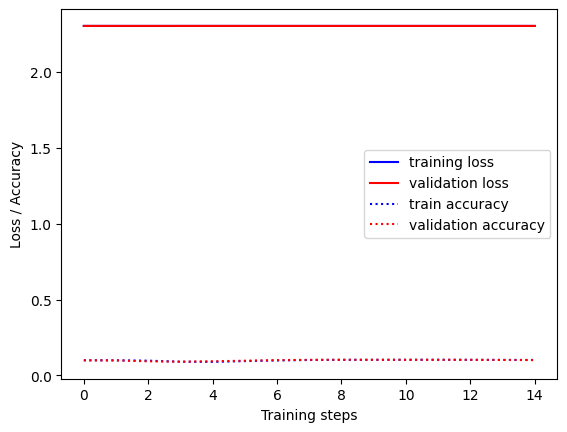

In [21]:
'''
7. Experiment

Learning rate: 0.0001
Architecture: [64,164,164,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.0001
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:41<00:00, 18.77it/s]


['loss: 2.3025522232055664', 'acc: 0.10239999741315842']
['val_loss: 2.302478075027466', 'val_acc: 0.12680000066757202']


Epoch 1: 100%|██████████| 782/782 [00:39<00:00, 19.97it/s]


['loss: 2.3024516105651855', 'acc: 0.11428000032901764']
['val_loss: 2.302382230758667', 'val_acc: 0.13019999861717224']


Epoch 2: 100%|██████████| 782/782 [00:39<00:00, 20.01it/s]


['loss: 2.3023386001586914', 'acc: 0.12396000325679779']
['val_loss: 2.302237033843994', 'val_acc: 0.13600000739097595']


Epoch 3: 100%|██████████| 782/782 [00:39<00:00, 20.01it/s]


['loss: 2.3021695613861084', 'acc: 0.13142000138759613']
['val_loss: 2.3020410537719727', 'val_acc: 0.14409999549388885']


Epoch 4: 100%|██████████| 782/782 [00:39<00:00, 20.05it/s]


['loss: 2.3019421100616455', 'acc: 0.13774000108242035']
['val_loss: 2.3017680644989014', 'val_acc: 0.14509999752044678']


Epoch 5: 100%|██████████| 782/782 [00:39<00:00, 20.00it/s]


['loss: 2.3016180992126465', 'acc: 0.13940000534057617']
['val_loss: 2.3013839721679688', 'val_acc: 0.14910000562667847']


Epoch 6: 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]


['loss: 2.301149606704712', 'acc: 0.14497999846935272']
['val_loss: 2.3008012771606445', 'val_acc: 0.15299999713897705']


Epoch 7: 100%|██████████| 782/782 [00:39<00:00, 19.57it/s]


['loss: 2.3004117012023926', 'acc: 0.15216000378131866']
['val_loss: 2.2998504638671875', 'val_acc: 0.14949999749660492']


Epoch 8: 100%|██████████| 782/782 [00:38<00:00, 20.27it/s]


['loss: 2.2991714477539062', 'acc: 0.15466000139713287']
['val_loss: 2.298198938369751', 'val_acc: 0.15209999680519104']


Epoch 9: 100%|██████████| 782/782 [00:38<00:00, 20.28it/s]


['loss: 2.2968766689300537', 'acc: 0.1567399948835373']
['val_loss: 2.294973611831665', 'val_acc: 0.15479999780654907']


Epoch 10: 100%|██████████| 782/782 [00:38<00:00, 20.06it/s]


['loss: 2.291963815689087', 'acc: 0.1582999974489212']
['val_loss: 2.2873294353485107', 'val_acc: 0.16099999845027924']


Epoch 11: 100%|██████████| 782/782 [00:39<00:00, 20.03it/s]


['loss: 2.2772724628448486', 'acc: 0.16053999960422516']
['val_loss: 2.2591419219970703', 'val_acc: 0.16099999845027924']


Epoch 12: 100%|██████████| 782/782 [00:39<00:00, 20.04it/s]


['loss: 2.224565267562866', 'acc: 0.17005999386310577']
['val_loss: 2.1921918392181396', 'val_acc: 0.17880000174045563']


Epoch 13: 100%|██████████| 782/782 [00:38<00:00, 20.06it/s]


['loss: 2.171384572982788', 'acc: 0.18445999920368195']
['val_loss: 2.1594340801239014', 'val_acc: 0.18320000171661377']


Epoch 14: 100%|██████████| 782/782 [00:39<00:00, 19.83it/s]


['loss: 2.115572452545166', 'acc: 0.19990000128746033']
['val_loss: 2.0719969272613525', 'val_acc: 0.20399999618530273']


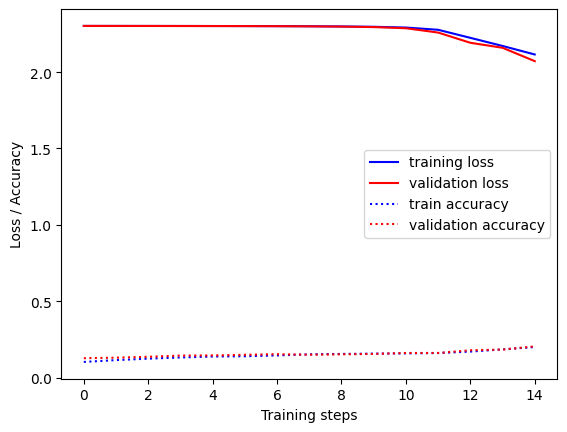

In [22]:
'''
8. Experiment

Learning rate: 0.002
Architecture: [64,164,164,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.002
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)